# **PHAS0102 - Assignment 4**

Student ID: 24022849

### **Part 1: Time Dependant Problems: implementing finite differences schemes (explicit and implicit) using CPU methods** ###

Introduction / context:

In the context of this problem the von Neumann stability factor (dt/dx²) was used for our heat equation. The Courant number (c*dt/dx) seen in the 1D wave equation in class and the von Neumann stability factor both govern numerical stability but reflect different physical processes. The Courant number ensures numerical waves don't outpace physical wave speed (CFL ≤ 1), while our heat equation's condition (dt/dx² ≤ 0.25 in 2D) manages diffusive spreading. This fundamental difference appears in their mathematical form: first spatial derivatives for waves versus second spatial derivatives for heat, resulting in distinct stability constraints despite both relating temporal and spatial discretization.

We derive the von Neumann stability factor for this problem by:

1. Using central differences for space (Δu):
Δu ≈ (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1] - 4u[i,j])/dx²

2. Taking the Forward Euler for time:
(u^(n+1) - u^n)/dt = Δu^n

3. Substituting the discrete Laplacian into the time discretization:
u^(n+1) = u^n + (dt/dx²)(u[i+1,j]^n + u[i-1,j]^n + u[i,j+1]^n + u[i,j-1]^n - 4u[i,j]^n)

4. For von Neumann stability analysis, let:
u[i,j]^n = ξ^n exp(iαi + iβj)
where ξ is the amplification factor

5. Substituting:
ξ = 1 + (dt/dx²)(exp(iα) + exp(-iα) + exp(iβ) + exp(-iβ) - 4)
  = 1 + (dt/dx²)(2cos(α) + 2cos(β) - 4)
  = 1 - 4(dt/dx²)(1 - (cos(α) + cos(β))/2)

6. For stability need |ξ| ≤ 1, which leads to:
dt/dx² ≤ 0.25

Thus we arrive at the stability condition dt/dx² ≤ 0.25 for the 2D heat equation.

In the following sections a) and b) we build the Explict (Forward) and Implicit (Backward) schemes respectively and in c) we will build all the functions used to analyse our schemes.

a) Explicit scheme (Forward Euler)

In [ ]:
import numpy as np
from numba import njit

@njit
def forward_euler_step(u, dx, dt):
    """
    Single step of Forward Euler method
    For 2D heat equation: du/dt = d²u/dx² + d²u/dy²
    Forward Euler approximation: (u^(n+1) - u^n)/dt = (central differences for Laplacian at time n)

    Von Neumann stability analysis requires: dt/(dx^2) ≤ 0.25 in 2D
    """
    u_new = u.copy()
    u_new[1:-1, 1:-1] = u[1:-1, 1:-1] + (dt/dx**2) * (
        u[2:, 1:-1] +    # up
        u[:-2, 1:-1] +   # down
        u[1:-1, 2:] +    # right
        u[1:-1, :-2] -   # left
        4 * u[1:-1, 1:-1] # center
    )
    return u_new

@njit
def get_center_temp(u, n_points):
    """Get temperature at center point"""
    return u[n_points//2, n_points//2]

def solve_forward_euler(n_points, dt, L):
    """
    Solve 2D heat equation using Forward Euler method until center reaches temperature 1.0

    Parameters:
    -----------
    n_points : int
        Number of grid points in each dimension
    dt : float
        Time step size (should satisfy dt/(dx^2) ≤ 0.25 for stability)
    L : float
        Domain length

    Returns:
    --------
    time : float
        Time taken to reach center temperature of 1.0
    u_initial : ndarray
        Initial temperature field
    u : ndarray
        Final temperature field
    max_values : ndarray
        Maximum temperature at each time step
    """
    dx = L / (n_points - 1)
    n = n_points * n_points
    stability_factor = dt / (dx * dx)
    print(f"\nForward Euler Solver")
    print(f"Grid size: {n_points}x{n_points}")
    print(f"dx: {dx:.8f}")
    print(f"dt: {dt:.8f}")
    print(f"Forward Euler stability number (dt/dx²): {stability_factor:.6f}")

    # Initialize solution
    u = np.zeros((n_points, n_points), dtype=np.float32)
    u[:, -1] = 5.0  # Right boundary

    u_initial = u.copy()
    max_values = [np.max(u)]
    physical_time = 0.0

    while get_center_temp(u, n_points) < 1.0:
        u = forward_euler_step(u, dx, dt)
        # Apply boundary conditions
        u[:, -1] = 5.0
        u[0, :] = u[-1, :] = u[:, 0] = 0.0

        physical_time += dt
        max_values.append(np.max(u))

        # Monitor center temperature
        center_temp = get_center_temp(u, n_points)

        # Check for instability
        if np.max(np.abs(u)) > 100:
            print(f"Warning: Forward Euler became unstable at t={physical_time:.6f}")
            break

    return physical_time, u_initial, u, np.array(max_values), center_temp

b) Implicit scheme (Backward Euler)

In [ ]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
from numba import njit
from time import perf_counter

@njit
def assemble_laplacian_numba(n_points, dx):
    """
    Fast matrix assembly using Numba
    Returns arrays for constructing sparse matrix
    """
    n = n_points * n_points
    # Pre-calculate number of non-zeros
    n_internal = (n_points - 2) * (n_points - 2)  # internal points with 5 entries
    n_boundary = 4 * (n_points - 1)  # boundary points with 1 entry
    nnz = 5 * n_internal + n_boundary

    # Pre-allocate arrays
    rows = np.zeros(nnz, dtype=np.int32)
    cols = np.zeros(nnz, dtype=np.int32)
    data = np.zeros(nnz, dtype=np.float64)

    idx = 0
    for i in range(n_points):
        for j in range(n_points):
            row = i * n_points + j

            if i == 0 or i == n_points-1 or j == 0 or j == n_points-1:
                # Boundary points
                rows[idx] = row
                cols[idx] = row
                data[idx] = 1.0
                idx += 1
            else:
                # Interior points - 5-point stencil
                # Center
                rows[idx] = row
                cols[idx] = row
                data[idx] = -4.0
                idx += 1

                # Up
                rows[idx] = row
                cols[idx] = row - n_points
                data[idx] = 1.0
                idx += 1

                # Down
                rows[idx] = row
                cols[idx] = row + n_points
                data[idx] = 1.0
                idx += 1

                # Left
                rows[idx] = row
                cols[idx] = row - 1
                data[idx] = 1.0
                idx += 1

                # Right
                rows[idx] = row
                cols[idx] = row + 1
                data[idx] = 1.0
                idx += 1

    return rows, cols, data / (dx * dx)

def create_2d_laplacian(n_points, dx):
    """
    Create sparse Laplacian matrix using Numba-accelerated assembly
    """
    n = n_points * n_points
    rows, cols, data = assemble_laplacian_numba(n_points, dx)
    return sparse.csr_matrix((data, (rows, cols)), shape=(n, n))

@njit
def get_center_temp(u, n_points):
    """Get temperature at center point"""
    return u[n_points//2, n_points//2]

def solve_backward_euler(n_points, dt, L):
    """
    Solve 2D heat equation using Backward Euler method until center reaches temperature 1.0

    Parameters:
    -----------
    n_points : int
        Number of grid points in each dimension
    dt : float
        Time step size (unconditionally stable, but larger dt affects accuracy)
    L : float
        Domain length

    Returns:
    --------
    time : float
        Time taken to reach center temperature of 1.0
    u_initial : ndarray
        Initial temperature field
    u : ndarray
        Final temperature field
    max_values : ndarray
        Maximum temperature at each time step
    center_temp : float
        Final temperature at center point
    """
    dx = L / (n_points - 1)
    n = n_points * n_points
    stability_factor = dt / (dx * dx)
    print(f"\nBackward Euler Solver")
    print(f"Grid size: {n_points}x{n_points}")
    print(f"dx: {dx:.8f}")
    print(f"dt: {dt:.8f}")
    print(f"Backward Euler stability number (dt/dx²): {stability_factor:.6f}")

    # Create system matrices
    start_time = perf_counter()

    # Create the Laplacian matrix
    A = create_2d_laplacian(n_points, dx)
    I = sparse.eye(n, format='csr')

    # Create implicit system matrix: (I - dt*A)
    A_implicit = (I - dt * A).tocsr()

    # Modify matrix for boundary conditions
    for i in range(n_points):
        for j in range(n_points):
            if i == 0 or i == n_points-1 or j == 0 or j == n_points-1:
                row = i * n_points + j
                A_implicit.data[A_implicit.indptr[row]:A_implicit.indptr[row+1]] = 0.0
                A_implicit[row, row] = 1.0

    A_implicit.eliminate_zeros()
    print(f"Matrix setup time: {perf_counter() - start_time:.2f} seconds")

    # Initialize solution
    u = np.zeros((n_points, n_points), dtype=np.float64)
    u[:, -1] = 5.0  # Right boundary

    u_initial = u.copy()
    max_values = [np.max(u)]

    # Time stepping loop
    physical_time = 0.0
    solve_start = perf_counter()
    steps = 0

    while get_center_temp(u, n_points) < 1.0:
        # Create right-hand side
        b = u.reshape(-1).copy()

        # Set boundary values in right-hand side
        for i in range(n_points):
            for j in range(n_points):
                idx = i * n_points + j
                if i == 0 or i == n_points-1 or j == 0:
                    b[idx] = 0.0
                elif j == n_points-1:
                    b[idx] = 5.0

        # Solve system
        x = spsolve(A_implicit, b)
        u = x.reshape((n_points, n_points))

        # Update time
        physical_time += dt
        max_values.append(np.max(u))
        steps += 1

        # Monitor center temperature
        center_temp = get_center_temp(u, n_points)

        if steps % 100 == 0:
            elapsed = perf_counter() - solve_start
            print(f"Step {steps}, Time {physical_time:.8f}, "
                  f"Center temp: {center_temp:.8f}")

    return physical_time, u_initial, u, np.array(max_values), center_temp

c) Create set of functions used for:

1. Checking and plotting the convergence of both schemes to t* = 0.424011387033 as the number of discretisation points increases.
2. Numerically investigate the stability of both schemes: we will investigate a set of stability factors (which determine the size of the time step) and their impact on the simulation, plot the maximum temperature reached for each factor and add some visuals of the plate in its initial state and final state (i.e. when the temperature at the center reaches 1) for each factor analysed.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from time import time as current_time

# Physical parameters and configuration common for all functions
L = 2  # Domain length [-1, 1] -> length = 2
t_exact = 0.424011387033  # Known exact time for center temperature = 1

# Convergence study function
def run_convergence_study(grid_sizes, stability_factor_forward, stability_factor_backward):
    """Run and plot convergence study for both methods using appropriate timesteps"""
    results = {
        "forward": {'times': [], 'errors': [], 'compute_times': [], 'final_temperature': []},
        "backward": {'times': [], 'errors': [], 'compute_times': [], 'final_temperature': []}
    }

    for grid_size in grid_sizes:
        dx = L / (grid_size - 1)

        # Forward Euler: use conservative timestep
        dt_forward = stability_factor_forward * dx * dx
        start_time = current_time()
        t_final, _, _, _, center_temp = solve_forward_euler(grid_size, dt_forward, L)
        compute_time = current_time() - start_time
        error = abs(t_exact - t_final)
        results["forward"]['times'].append(t_final)
        results["forward"]['errors'].append(error)
        results["forward"]['compute_times'].append(compute_time)
        results["forward"]['final_temperature'].append(center_temp)
        print(f"Forward Euler - Grid: {grid_size}, Center Temperature Result: {center_temp:.6f}, Physical Time Result: {t_final:.6f}, Error: {error:.6f}, Compute Time: {compute_time:.3f}s")

        # Backward Euler: can use larger timestep
        dt_backward = stability_factor_backward * dx * dx
        start_time = current_time()
        t_final, _, _, _, center_temp = solve_backward_euler(grid_size, dt_backward, L)
        compute_time = current_time() - start_time
        error = abs(t_exact - t_final)
        results["backward"]['times'].append(t_final)
        results["backward"]['errors'].append(error)
        results["backward"]['compute_times'].append(compute_time)
        results["backward"]['final_temperature'].append(center_temp)
        print(f"Backward Euler - Grid: {grid_size}, Center Temperature Result: {center_temp:.6f}, Physical Time Result: {t_final:.6f}, Error: {error:.6f}, Compute Time: {compute_time:.3f}s")

    # Plot results
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Convergence plot
    for method in results:
        ax1.plot(grid_sizes, results[method]['times'], marker='o',
                label=f"{method.capitalize()} Euler")
    ax1.axhline(y=t_exact, color='k', linestyle='--', label='t* = 0.42401138703')
    ax1.set_xlabel("Grid size")
    ax1.set_ylabel("Time to reach center temperature = 1")
    ax1.set_title("Convergence Comparison")
    ax1.legend()
    ax1.grid(True)

    # Error plot
    for method in results:
        ax2.plot(grid_sizes, results[method]['errors'], marker='o',
                label=f"{method.capitalize()} Euler")
    ax2.set_xlabel("Grid size")
    ax2.set_ylabel("Error")
    ax2.set_title("Error Analysis")
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True)

    # Computation time plot
    for method in results:
        ax3.plot(grid_sizes, results[method]['compute_times'], marker='o',
                label=f"{method.capitalize()} Euler")
    ax3.set_xlabel("Grid size")
    ax3.set_ylabel("Computation time (s)")
    ax3.set_title("Performance Comparison")
    ax3.set_yscale('log')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

# Stability Analysis function
def run_stability_analysis(grid_size, stability_factors_forward, stability_factors_backward):
    """Run and plot stability analysis showing different stability properties"""
    grid_size = grid_size
    dx = L / (grid_size - 1)

    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Forward Euler plot
    for st_factor in stability_factors_forward:
        dt = st_factor * dx * dx
        tfinal, _, _, maxvalues, _ = solve_forward_euler(grid_size, dt, L)
        timesteps = np.arange(len(maxvalues)) * dt

        ax1.plot(timesteps, maxvalues,
                label=f'dt/dx² = {st_factor:.3f}')

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Maximum Temperature')
    ax1.set_title(f'Forward Euler\nGrid Size {grid_size}x{grid_size}')
    ax1.legend()
    ax1.grid(True)

    # Backward Euler plot
    for st_factor in stability_factors_backward:
        dt = st_factor * dx * dx
        tfinal, _, _, maxvalues, _ = solve_backward_euler(grid_size, dt, L)
        timesteps = np.arange(len(maxvalues)) * dt

        ax2.plot(timesteps, maxvalues,
                label=f'dt/dx² = {st_factor:.3f}')

    ax2.set_xlabel('Time')
    ax2.set_ylabel('Maximum Temperature')
    ax2.set_title(f'Backward Euler\nGrid Size {grid_size}x{grid_size}')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Solution fields function
def plot_solution_fields(grid_size, stability_factor_forward, stability_factor_backward):
    """Plot initial and final temperature fields for both methods"""
    grid_size = grid_size
    dx = L / (grid_size - 1)

    # Forward Euler
    dt_forward = stability_factor_forward * dx * dx
    _, initial_f, final_f, _, _ = solve_forward_euler(grid_size, dt_forward, L)

    # Backward Euler
    dt_backward = stability_factor_backward * dx * dx
    _, initial_b, final_b, _, _ = solve_backward_euler(grid_size, dt_backward, L)

    # Plot all results in a 2x2 grid
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

    # Forward Euler results
    im1 = ax1.imshow(initial_f, extent=[-1, 1, -1, 1], origin='lower', cmap='hot')
    plt.colorbar(im1, ax=ax1, label='Temperature')
    ax1.set_title(f"Initial Condition: N = {grid_size}\nForward Euler (dt/dx² = {stability_factor_forward})")
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    im2 = ax2.imshow(final_f, extent=[-1, 1, -1, 1], origin='lower', cmap='hot')
    plt.colorbar(im2, ax=ax2, label='Temperature')
    ax2.set_title(f"Final Condition: N = {grid_size}\nForward Euler (dt/dx² = {stability_factor_forward})")
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')

    # Backward Euler results
    im3 = ax3.imshow(initial_b, extent=[-1, 1, -1, 1], origin='lower', cmap='hot')
    plt.colorbar(im3, ax=ax3, label='Temperature')
    ax3.set_title(f"Initial Condition: N = {grid_size}\nBackward Euler (dt/dx² = {stability_factor_backward})")
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')

    im4 = ax4.imshow(final_b, extent=[-1, 1, -1, 1], origin='lower', cmap='hot')
    plt.colorbar(im4, ax=ax4, label='Temperature')
    ax4.set_title(f"Final Condition: N = {grid_size}\nBackward Euler (dt/dx² = {stability_factor_backward})")
    ax4.set_xlabel('x')
    ax4.set_ylabel('y')

    plt.tight_layout()
    plt.show()

c1) Convergence analysis

We run both schemes for different grid sizes. The choice of the stability factor has several trade offs, some of which are described below.

Forward Euler:

*   Must keep dt/(dx²) ≤ 0.25 for stability in 2D in a heat equation (ut = Δu)
*   Smaller values = more accurate but more time steps needed
*   Larger values (approaching 0.25) = faster computation but risk instability
*   If dt/(dx²) > 0.25: solution will become unstable and oscillate

Using the Explicit method means each step is computationally cheap, but the stability restriction means many small steps required.

Backward Euler:

*   Unconditionally stable for any dt/(dx²)
*   Each step more expensive (must solve linear system)
*   The smaller the stability factor dt/(dx²) the more accurate the scheme will be (closer to the "true" solution", but more time steps will be required making it computationally more expensive

In this exercise we are running the Forward Euler scheme at the stability limit (i.e. dt/(dx²) = 0.25) and the Backward Euler scheme at 16. These are relativily large factors but will allows to run several grid sizes in acceptable times and still achieve a decent level of precision.

<IPython.core.display.Javascript object>


Forward Euler Solver
Grid size: 100x100
dx: 0.02020202
dt: 0.00010203
Forward Euler stability number (dt/dx²): 0.250000
Forward Euler - Grid: 100, Center Temperature Result: 1.000021, Physical Time Result: 0.407713, Error: 0.016298, Compute Time: 2.395s

Backward Euler Solver
Grid size: 100x100
dx: 0.02020202
dt: 0.00652995
Backward Euler stability number (dt/dx²): 16.000000
Matrix setup time: 0.86 seconds
Backward Euler - Grid: 100, Center Temperature Result: 1.004681, Physical Time Result: 0.417917, Error: 0.006095, Compute Time: 3.701s

Forward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.00004504
Forward Euler stability number (dt/dx²): 0.250000
Forward Euler - Grid: 150, Center Temperature Result: 1.000048, Physical Time Result: 0.413090, Error: 0.010922, Compute Time: 3.810s

Backward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.00288275
Backward Euler stability number (dt/dx²): 16.000000
Matrix setup time: 0.04 seconds
Step 100, Time 0.28827530, Center temp: 0.7

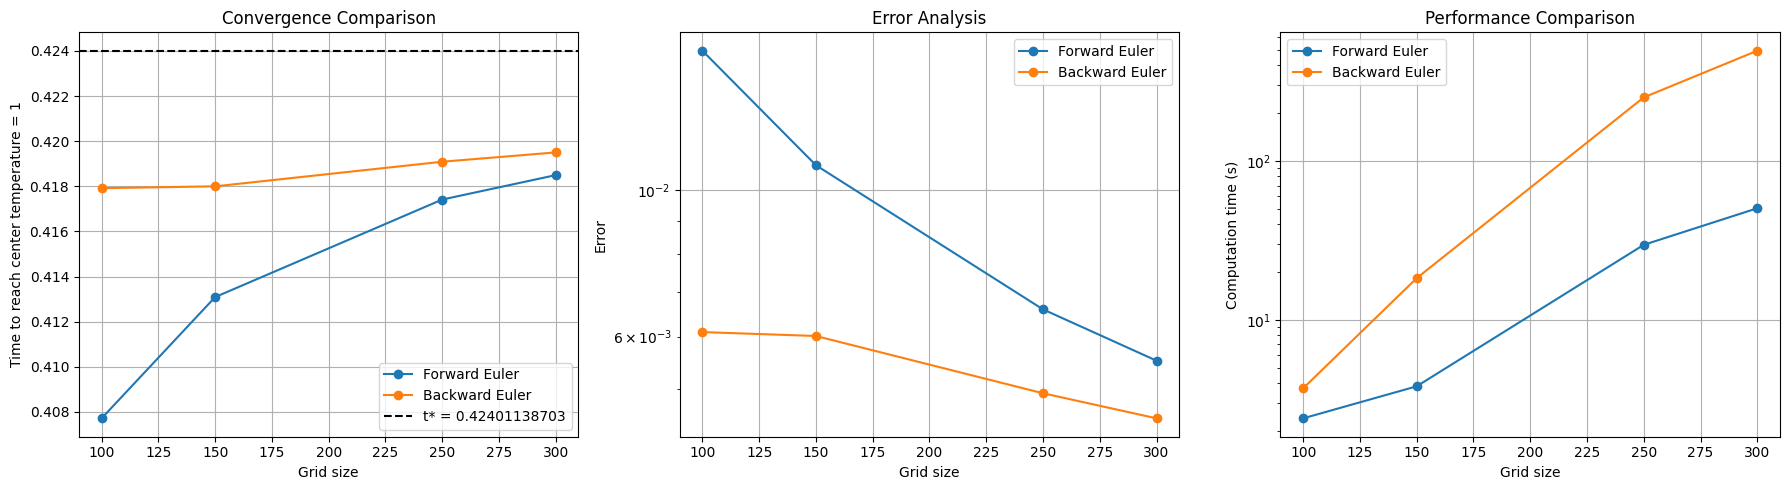

In [ ]:
from google.colab import output
output.no_vertical_scroll()

# Grid configurations
grid_sizes = [100, 150, 250, 300] # Main grid sizes for convergence study

# Set stability factor
stability_factor_forward = 0.25  # Stability factor for Forward Euler
stability_factor_backward = 16  # Stability factor for Backward Euler

run_convergence_study(grid_sizes, stability_factor_forward, stability_factor_backward)

c2) Numerical investigation of the stability of both schemes

In this analysis we will fix the grid size at 150x150 (choosing this size so that solving and plotting does not take too long) and run both schemes with different stability factors.

For the Forward Euler we will run some below the 0.25 limit and some above to see if the solution does keep stability below the limit and loses it above the limit.

We do not expect the Backward Euler method to lose stability at any factor, so we will start with a factor slightly below the one used in the convergence analysis and scale it up a fair bit to see if stability is maintained.

The script checks the maximum temperature values across the grid and how they change when running with different stability factors.

<IPython.core.display.Javascript object>


Forward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.00001802
Forward Euler stability number (dt/dx²): 0.100000

Forward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.00003603
Forward Euler stability number (dt/dx²): 0.200000

Forward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.00004504
Forward Euler stability number (dt/dx²): 0.250000

Forward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.00009009
Forward Euler stability number (dt/dx²): 0.500000

Forward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.00013513
Forward Euler stability number (dt/dx²): 0.750000

Forward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.00018017
Forward Euler stability number (dt/dx²): 1.000000

Backward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.00144138
Backward Euler stability number (dt/dx²): 8.000000
Matrix setup time: 0.06 seconds
Step 100, Time 0.14413765, Center temp: 0.30140223
Step 200, Time 0.28827530, Center temp: 0.77328956

Backward Euler S

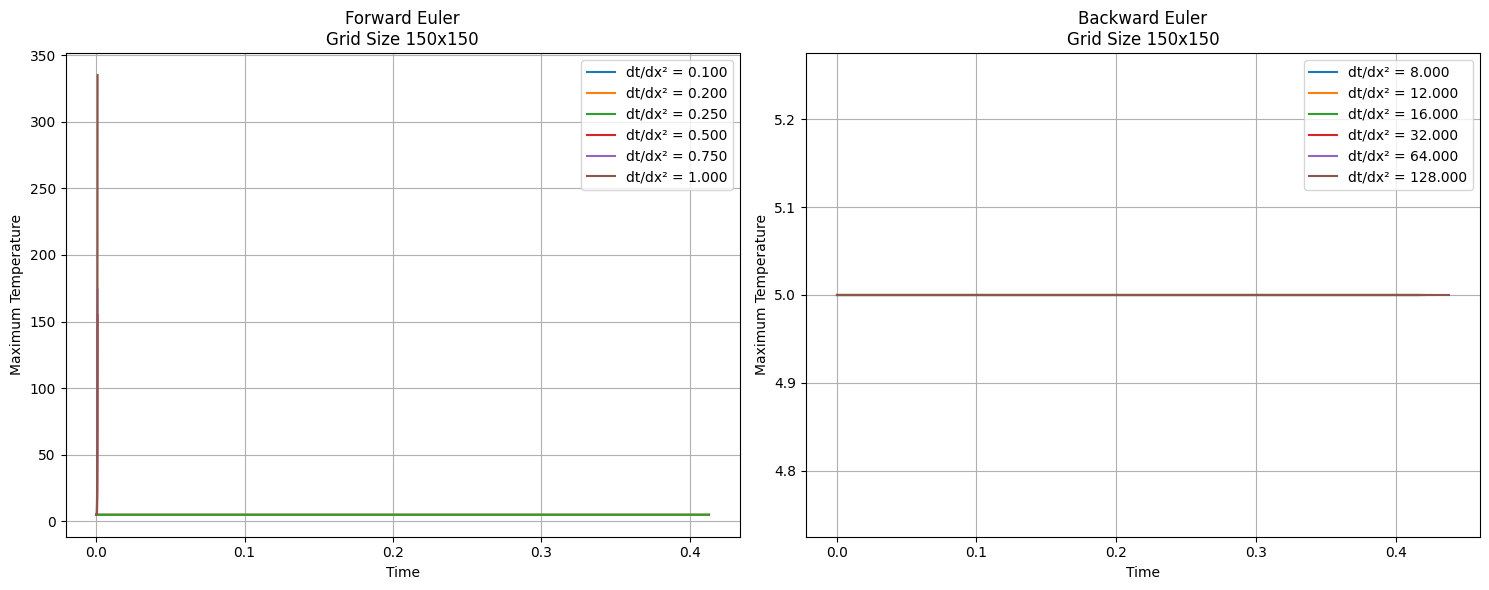

In [ ]:
from google.colab import output
output.no_vertical_scroll()

# Fixed grid size for stability factor comparison
grid_size = grid_sizes[1]

stability_factors_forward = [0.1, 0.2, 0.25, 0.5, 0.75, 1] # first three within stability limit, last three outside
stability_factors_backward = [8.0, 12.0, 16.0, 32.0, 64.0, 128.0] # Can use much larger steps
run_stability_analysis(grid_size, stability_factors_forward, stability_factors_backward)


The above plots show that the maximum temperature across the grid during our simulations never exceeds 5 for the Backward Euler scheme. However, for the Forward Euler scheme we can see that some simulations "exploded". This is not very clear in a line graph since several lines are likely overlapping.

We will look at them individually by plotting the 2D heat map for each factor.

We've plotted our set of stability factors in pairs, one per method.

<IPython.core.display.Javascript object>


Forward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.00001802
Forward Euler stability number (dt/dx²): 0.100000

Backward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.00144138
Backward Euler stability number (dt/dx²): 8.000000
Matrix setup time: 0.04 seconds
Step 100, Time 0.14413765, Center temp: 0.30140223
Step 200, Time 0.28827530, Center temp: 0.77328956


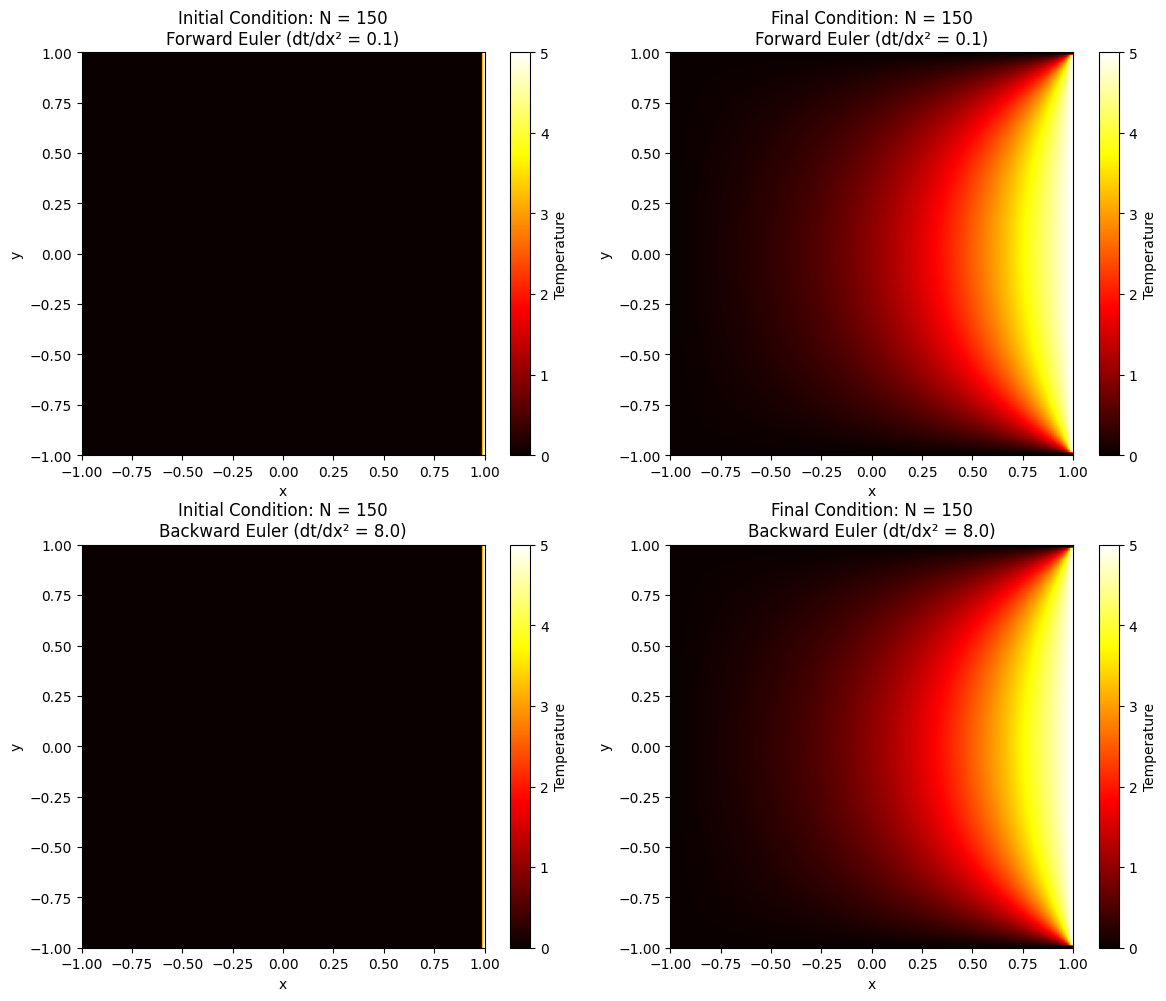


Forward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.00003603
Forward Euler stability number (dt/dx²): 0.200000

Backward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.00216206
Backward Euler stability number (dt/dx²): 12.000000
Matrix setup time: 0.04 seconds
Step 100, Time 0.21620648, Center temp: 0.56794706


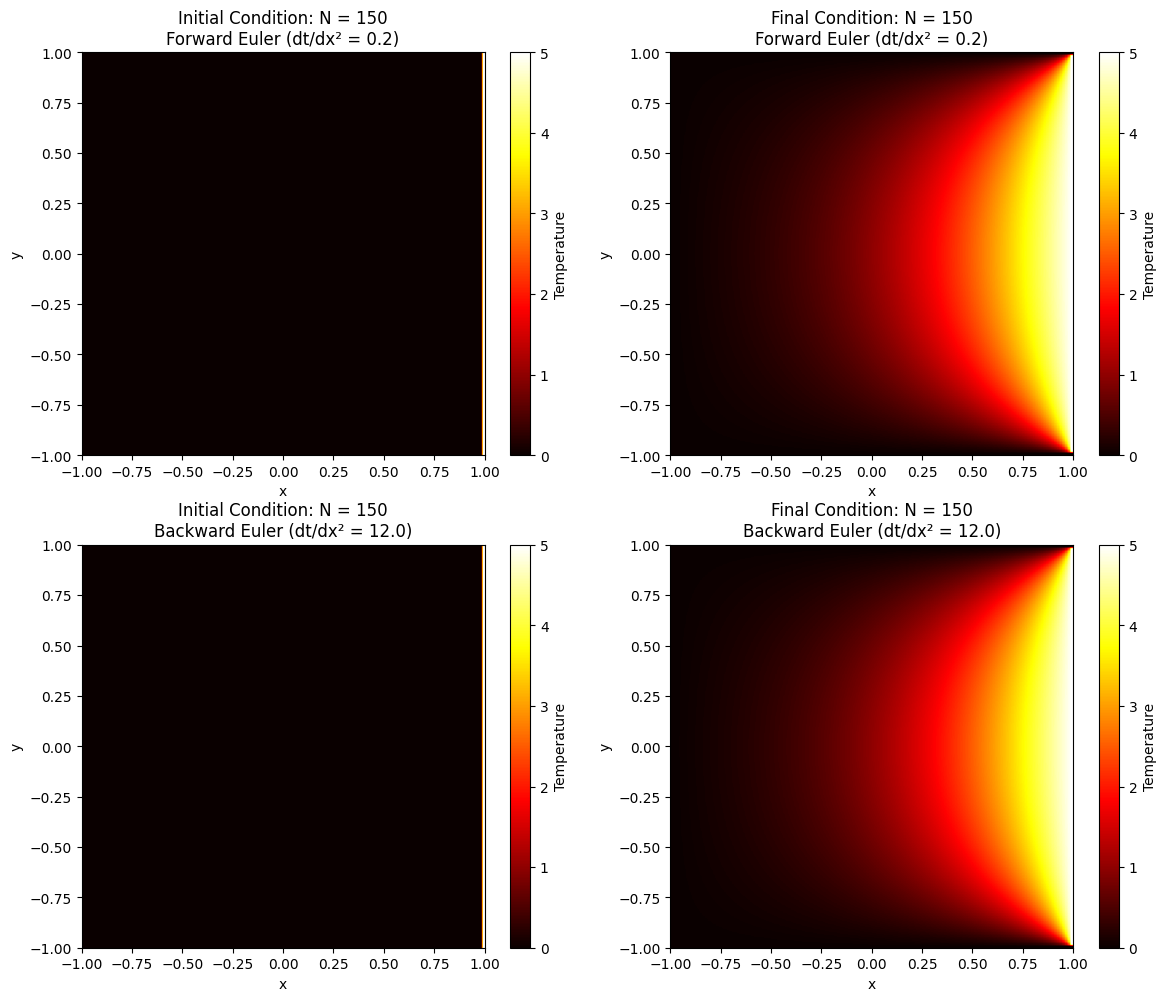


Forward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.00004504
Forward Euler stability number (dt/dx²): 0.250000

Backward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.00288275
Backward Euler stability number (dt/dx²): 16.000000
Matrix setup time: 0.07 seconds
Step 100, Time 0.28827530, Center temp: 0.77095928


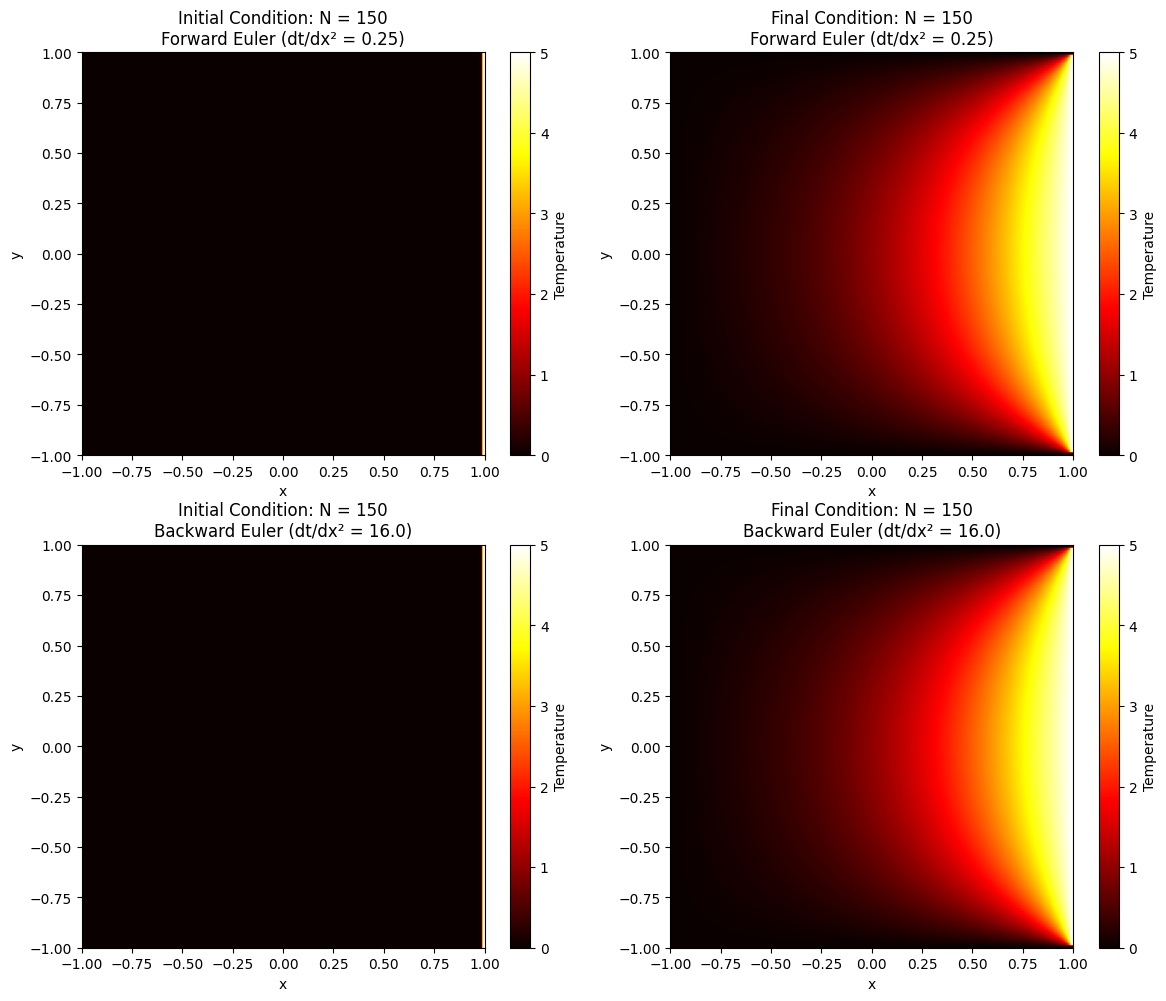


Forward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.00009009
Forward Euler stability number (dt/dx²): 0.500000

Backward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.00576551
Backward Euler stability number (dt/dx²): 32.000000
Matrix setup time: 0.06 seconds


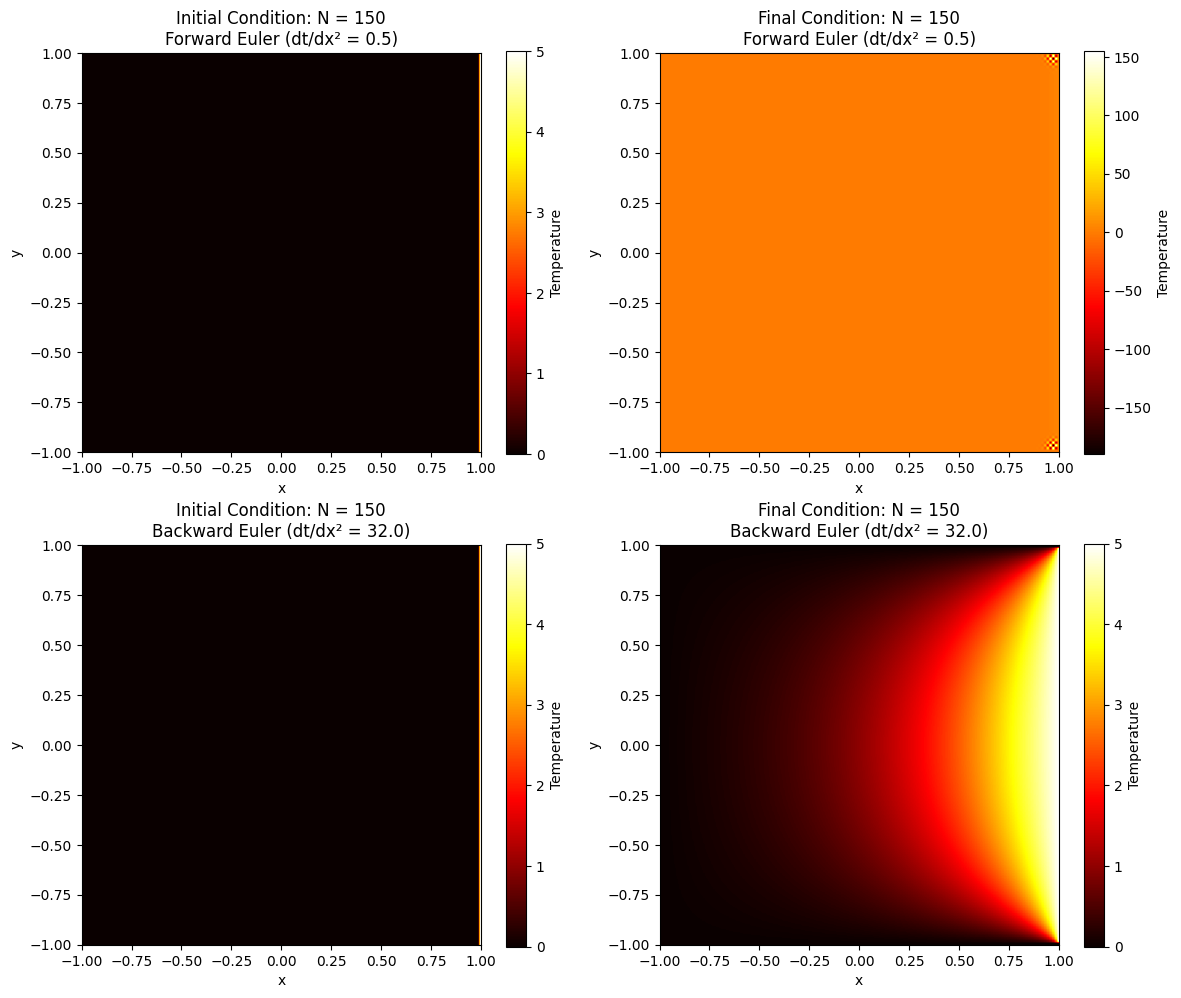


Forward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.00013513
Forward Euler stability number (dt/dx²): 0.750000

Backward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.01153101
Backward Euler stability number (dt/dx²): 64.000000
Matrix setup time: 0.06 seconds


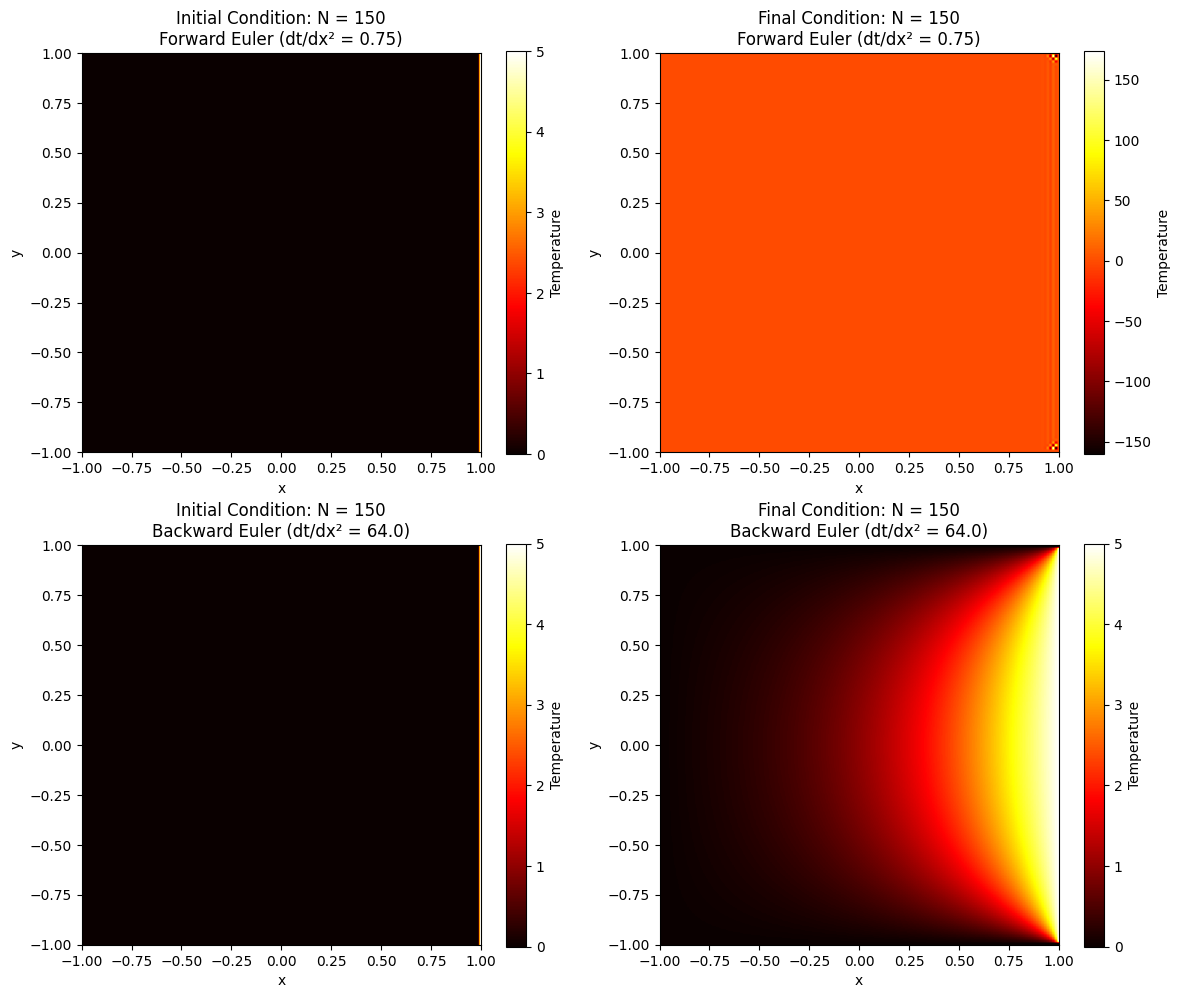


Forward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.00018017
Forward Euler stability number (dt/dx²): 1.000000

Backward Euler Solver
Grid size: 150x150
dx: 0.01342282
dt: 0.02306202
Backward Euler stability number (dt/dx²): 128.000000
Matrix setup time: 0.07 seconds


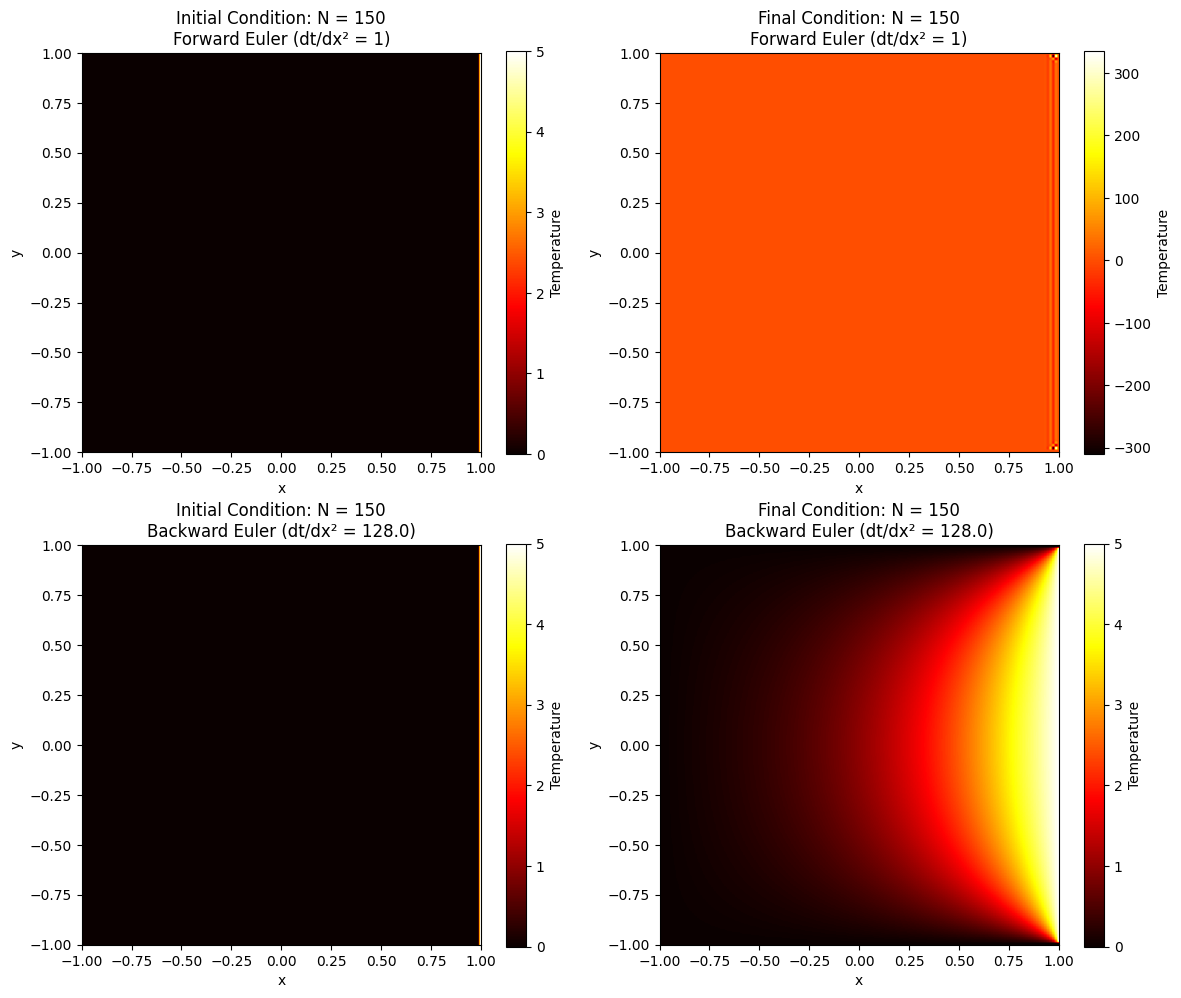

In [ ]:
from google.colab import output
output.no_vertical_scroll()
import warnings
warnings.filterwarnings('ignore', category=sparse.SparseEfficiencyWarning) # ignoring warnings in order to keep result space readable

# Fixed grid size for stability factor comparison
grid_size = grid_sizes[1]

# Timestep factors for each method based on their stability properties:
# Forward Euler: must have dt/(dx^2) ≤ 1/4 for stability in 2D

stability_factors_forward = [0.1, 0.2, 0.25, 0.5, 0.75, 1] # first three within stability limit, last three outside
stability_factors_backward = [8.0, 12.0, 16.0, 32.0, 64.0, 128.0] # Can use much larger steps

for sff, sfb in zip(stability_factors_forward, stability_factors_backward):
    plot_solution_fields(grid_size, stability_factor_forward=sff, stability_factor_backward=sfb)

One thing that is immediately visible for all simulations is that the right hand side is heated up to 5 degrees in all initial states (small white vertical stripe on the righthand side, which will be wider if the resolution of the grid is lower and vice versa) as indicated in the problem's requirements.


By looking at the above plots we can confirm that the Backward Euler scheme mantains stability regardless of what factor (and, consequently what the size of the time step is) while the Forward Euler scheme becomes unstable as soon as we go above our stability factor limit of 0.25.

### **Part 2: Time Dependant Problems: implementing finite differences explicit scheme using GPU methods** ###

a) Setting up the Forward Euler solver adapted for GPU

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import math

# GPU kernel for explicit time-stepping
@cuda.jit
def forward_euler_gpu(u, u_new, N, dt, dx2, center_value):
    idx = cuda.grid(1)
    if idx < N * N:
        i = idx // N  # Row index
        j = idx % N  # Column index

        # Skip boundary points
        if i == 0 or i == N - 1 or j == 0 or j == N - 1:
            u_new[idx] = u[idx]
        else:
            # Compute Laplacian using neighbours
            laplacian = (u[idx - 1] + u[idx + 1] + u[idx - N] + u[idx + N] - 4 * u[idx]) / dx2
            u_new[idx] = u[idx] + dt * laplacian

        # Update the center value (shared memory or global)
        if idx == (N // 2) * N + (N // 2):
            center_value[0] = u_new[idx]

# GPU kernel for initialization
@cuda.jit
def initialize_boundary_conditions(u, N):
    idx = cuda.grid(1)
    if idx < N * N:
        i = idx // N
        j = idx % N
        if j == N - 1:
            u[idx] = 5
        elif i == 0 or i == N - 1 or j == 0:
            u[idx] = 0

# GPU accelerated heat equation solver
def solve_heat_equation_gpu(N, dt, method="Forward Euler"):
    dx = L / (N - 1)
    dx2 = dx ** 2

    # Initialize arrays
    u = np.zeros(N * N, dtype=np.float32)
    u_new = np.zeros_like(u)

    # Apply boundary conditions
    threads_per_block = 256
    blocks_per_grid = math.ceil(u.size / threads_per_block)
    initialize_boundary_conditions[blocks_per_grid, threads_per_block](u, N)

    # Synchronize and copy back to the host to verify correctness
    cuda.synchronize()
    initial_condition = u.reshape((N, N)).copy()

    # Save initial condition before iteration
    initial_condition = u.reshape((N, N)).copy()

    # Copy to device
    d_u = cuda.to_device(u)
    d_u_new = cuda.to_device(u_new)
    d_center_value = cuda.to_device(np.array([0], dtype=np.float32))  # Device variable for center value

    time = 0

    while True:
        forward_euler_gpu[blocks_per_grid, threads_per_block](d_u, d_u_new, N, dt, dx2, d_center_value)
        cuda.synchronize()  # Ensure kernel completion
        d_u, d_u_new = d_u_new, d_u  # Swap the device arrays

        # Check center value without copying entire array
        center_value = d_center_value.copy_to_host()[0]
        if center_value >= 1:
            break

        time += dt

    # Final condition after iteration
    final_condition = d_u.copy_to_host().reshape((N, N)).copy()

    return time, initial_condition, final_condition, center_value

b) Running the solver. Since we are running on GPU we will increase the grid sizes used and reduce the stability factor to 0.1, implying a smaller time step for each grid size.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda, config
import math
from time import time as current_time
from google.colab import output
output.no_vertical_scroll()

config.CUDA_LOW_OCCUPANCY_WARNINGS = False

# Parameters
L = 2
t_exact = 0.42401138703
stability_factor_forward_gpu = 0.15

# Grid sizes
grid_sizes = [150, 300, 500, 1000, 1500]

# Supporting variables
convergence_results_gpu = []
all_initial_conditions = []
final_conditions = []
errors = []

for grid_size in grid_sizes:
    dx = L / (grid_size - 1)
    dt_forward_gpu = stability_factor_forward_gpu * dx * dx

    print(f"\nForward Euler Solver - GPU")
    print(f"Grid size: {grid_size}x{grid_size}")
    print(f"dx: {dx:.8f}")
    print(f"dt: {dt_forward_gpu:.8f}")
    print(f"Forward Euler stability number (dt/dx²): {stability_factor_forward_gpu:.6f}")

    start_time = current_time()

    t_gpu, initial_condition, final_condition, center_value = solve_heat_equation_gpu(grid_size, dt_forward_gpu, method="Forward Euler")

    convergence_results_gpu.append((grid_size, t_gpu))
    all_initial_conditions.append((grid_size, initial_condition))
    final_conditions.append((grid_size, final_condition))

    error = abs(t_exact - t_gpu)
    errors.append(error)

    compute_time = current_time() - start_time

    print(f"Forward Euler - Grid: {grid_size}, Center Temperature Result: {center_value:.6f}, Physical Time Result: {t_gpu:.6f}, Error: {error:.6f}, Compute Time: {compute_time:.3f}s")


# Plot GPU results as a line graph
plt.figure()
grid_sizes, times = zip(*convergence_results_gpu)
plt.plot(grid_sizes, times, marker='o', label="GPU Convergence Results")
plt.axhline(y=t_exact, color='k', linestyle='--', label=f't* = {t_exact}')
plt.xlabel("Grid size")
plt.ylabel("Time to reach center temperature = 1")
plt.title("GPU Convergence Results for Forward Euler")
plt.legend()
plt.grid()

# Plot error vs grid sizes
plt.figure()
plt.plot(grid_sizes, errors, marker='o', label="Error (|t* - result|)")
plt.xlabel("Grid size")
plt.ylabel("Error")
plt.title("Error Analysis for GPU Convergence Results")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot initial conditions before iteration for the first grid size
initial_grid_size, initial_condition = all_initial_conditions[0]
plt.figure()
plt.imshow(initial_condition, extent=[-1, 1, -1, 1], origin='lower', cmap='hot')
plt.colorbar(label='Temperature')
plt.title(f"Initial Condition (Before Iteration) for Grid Size {initial_grid_size}")
plt.xlabel('x')
plt.ylabel('y')

# Plot the grid after iteration for the first grid size
final_grid_size, final_condition = final_conditions[0]
plt.figure()
plt.imshow(final_condition, extent=[-1, 1, -1, 1], origin='lower', cmap='hot')
plt.colorbar(label='Temperature')
plt.title(f"Final Condition (After Iteration) for Grid Size {final_grid_size}")
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

# Plot initial conditions before iteration for the last grid size
initial_grid_size, initial_condition = all_initial_conditions[-1]
plt.figure()
plt.imshow(initial_condition, extent=[-1, 1, -1, 1], origin='lower', cmap='hot')
plt.colorbar(label='Temperature')
plt.title(f"Initial Condition (Before Iteration) for Grid Size {initial_grid_size}")
plt.xlabel('x')
plt.ylabel('y')

# Plot the grid after iteration for the last grid size
final_grid_size, final_condition = final_conditions[-1]
plt.figure()
plt.imshow(final_condition, extent=[-1, 1, -1, 1], origin='lower', cmap='hot')
plt.colorbar(label='Temperature')
plt.title(f"Final Condition (After Iteration) for Grid Size {final_grid_size}")
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

print("GPU Convergence Results with Errors:")
for i, (grid_size, t_gpu) in enumerate(convergence_results_gpu):
    print(f"Grid size: {grid_size}, Result: {t_gpu}, Error: {errors[i]}")


<IPython.core.display.Javascript object>

ERROR:numba.cuda.cudadrv.driver:Call to cuLinkAddData results in CUDA_ERROR_UNSUPPORTED_PTX_VERSION



Forward Euler Solver - GPU
Grid size: 150x150
dx: 0.01342282
dt: 0.00002703
Forward Euler stability number (dt/dx²): 0.150000


LinkerError: [222] Call to cuLinkAddData results in CUDA_ERROR_UNSUPPORTED_PTX_VERSION
ptxas application ptx input, line 9; fatal   : Unsupported .version 8.5; current version is '8.4'

Our GPU results clearly benefit from the higher grid resolution and smaller time steps used (implied by using a smaller stability factor).

The error behaves as in the CPU version, getting smaller as the grid size increases.

At N = 1500 and dt/(dx²) = 0.15 we even achieve precision of 3 digits (result of 0.4243992770918108) against our target time. One noticeable fact is that our physical time in this simulation actually goes over the target time, unlike simulations at smaller grid sizes. This indicates that at this grid size we would likely benefit from a small stability factor (and hence smaller time step size).

In addition, the heat maps of the plate at N = 1500 have so much resolution that the vertical stripe on the righthand side at temperature = 5 is not even visible.